In [1]:
from mitiq import about
about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.34.0

Core Dependencies
-----------------
Cirq Version:	1.3.0
NumPy Version:	1.23.5
SciPy Version:	1.11.4

Optional Dependencies
---------------------
PyQuil Version:	3.5.4
Qiskit Version:	0.43.3
Braket Version:	Not installed

Python Version:	3.10.10
Platform Info:	Darwin (arm64)


### In this Notebook I test that I am able to run some of Mitiq's tools by going through a few of their documented <a href="https://mitiq.readthedocs.io/en/stable/examples/examples.html">examples</a>

## Example 1: ZNE calibration w/ Qiskit

In [2]:
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import (
    fold_gates_at_random,
    fold_global,
    fold_all
)
from mitiq.zne.inference import LinearFactory, RichardsonFactory
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

from qiskit.providers.fake_provider import FakeJakarta 

In [3]:
# Define global variables for the quantum circuit of interest: number of qubits, depth of the quantum circuit and number of shots.

n_qubits = 2
depth_circuit = 100
shots = 10 ** 4

In [4]:
# Use Mitiq’s built-in generate_rb_circuits from the mitiq.benchmarks module to define the quantum circuit.

circuit = generate_rb_circuits(n_qubits, depth_circuit,return_type="qiskit")[0]
circuit.measure_all()
print(len(circuit))

1011


We define a function that executes the quantum circuits and returns the expectation value. This is consumed by Mitiq’s execute_with_zne. In this example, the expectation value is the probability of measuring the ground state, which is what one would expect from an ideal randomized benchmarking circuit.

In [5]:
def execute_circuit(circuit):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_backend = FakeJakarta()
    noisy_result = noisy_backend.run(circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(circuit)
    noisy_expectation_value = noisy_counts[n_qubits * "0"] / shots
    return noisy_expectation_value

In [6]:
# execute_site_zne() estimates the error-mitigated expectation value associated to the input circuit, via the application of zero-noise extrapolation (ZNE).

mitigated = execute_with_zne(circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated = execute_circuit(circuit)
ideal = 1 #property of RB circuits

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.81700
mitigated = 	 	 0.88090


#### Using calibration to improve the results <br>
Let’s consider a noisy backend using the Qiskit noisy simulator, FakeJakarta. Note that the executor passed to the Calibrator object must return counts, as opposed to expectation values.

In [7]:
def execute_calibration(qiskit_circuit):
    """Execute the input circuits and return the measurement results."""
    noisy_backend = FakeJakarta()
    noisy_result = noisy_backend.run(qiskit_circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(qiskit_circuit)
    noisy_counts = { k.replace(" ",""):v for k, v in noisy_counts.items()}
    measurements = MeasurementResult.from_counts(noisy_counts)
    return measurements

We import from the calibration module the key ingredients to use mitiq.calibration: the Calibrator class, the mitiq.calibration.settings.Settings class and the execute_with_mitigation function.

Currently mitiq.calibration supports ZNE as a technique to calibrate from, tuning different scale factors, extrapolation methods and circuit scaling methods.

Let’s run the calibration using an ad-hoc RBSettings while logging the results for comparison.

benchmarks: Circuit type: “rb”

strategies: use various “zne” strategies, testing various “scale_noise” methods (such as mitiq.zne.scaling.folding.fold_global, mitiq.zne.scaling.folding.fold_gates_at_random, and mitiq.zne.scaling.folding.fold_all), and ZNE factories for extrapolation (such as mitiq.zne.inference.RichardsonFactory and mitiq.zne.inference.LinearFactory)

In [8]:
RBSettings = Settings(
    benchmarks=[
        {
            "circuit_type": "rb",
            "num_qubits": 2,
            "circuit_depth": int(depth_circuit / 2),
        },
    ],
    strategies=[
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

    ],
)

In [9]:
cal = Calibrator(execute_calibration, frontend="qiskit", settings=RBSettings)
cal.run(log="flat")

┌──────────────────────────┬────────────────────────────────────┬────────────────────────────┐
│ benchmark                │ strategy                           │ performance                │
├──────────────────────────┼────────────────────────────────────┼────────────────────────────┤
│ Type: rb                 │ Technique: ZNE                     │ ✔                          │
│ Num qubits: 2            │ Factory: Linear                    │ Noisy error: 0.1028        │
│ Circuit depth: 329       │ Scale factors: 1.0, 2.0, 3.0       │ Mitigated error: 0.012     │
│ Two qubit gate count: 73 │ Scale method: fold_all             │ Improvement factor: 8.5429 │
├──────────────────────────┼────────────────────────────────────┼────────────────────────────┤
│ Type: rb                 │ Technique: ZNE                     │ ✔                          │
│ Num qubits: 2            │ Factory: Richardson                │ Noisy error: 0.1028        │
│ Circuit depth: 329       │ Scale factors: 1.0, 2

several experiments were run, and each one has either a cross (✘) or a check (✔) to signal whether the error mitigation experiment obtained an expectation value that is better than the non-mitigated one.

In [10]:
calibrated_mitigated=execute_with_mitigation(circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.81470
mitigated = 	 	 0.87307
calibrated_mitigated = 	 0.94727


## Example 2: GGI Summer School Hands-On Tutorial

In [11]:
from mitiq.benchmarks import generate_ghz_circuit

# Define the circuit of interest, here we prepares the GHZ state for n_qubits.


n_qubits = 7

circuit = generate_ghz_circuit(n_qubits=n_qubits, return_type="qiskit")
print("GHZ circuit:")
print(circuit)

GHZ circuit:
     ┌───┐                              
q_0: ┤ H ├──■───────────────────────────
     └───┘┌─┴─┐                         
q_1: ─────┤ X ├──■──────────────────────
          └───┘┌─┴─┐                    
q_2: ──────────┤ X ├──■─────────────────
               └───┘┌─┴─┐               
q_3: ───────────────┤ X ├──■────────────
                    └───┘┌─┴─┐          
q_4: ────────────────────┤ X ├──■───────
                         └───┘┌─┴─┐     
q_5: ─────────────────────────┤ X ├──■──
                              └───┘┌─┴─┐
q_6: ──────────────────────────────┤ X ├
                                   └───┘


We then define a Hermitian observable that in the absence of noise, has an expectation value of 1 for the GHZ state
 
In practice this means that, when measuring the state in the computational basis, we can only obtain either the bitstring 00...0 or 11...1 the biststring 

In the presence of noise instead, the expectation value of the same observable will be smaller. Let’s verify this fact, before applying any error mitigation.

In [12]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
from qiskit.providers.fake_provider import FakeJakarta  # Fake (simulated) QPUs

# Number of measurements
shots = 10 ** 5

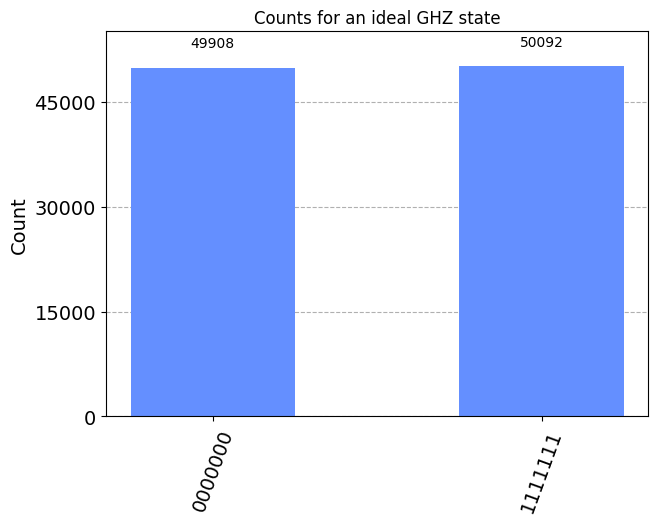

In [13]:
from qiskit import execute

# We first execute the circuit on an ideal noiseless simulator.

ideal_backend = AerSimulator()

# Append measurement gates
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# TODO: Run circuit_to_run on the ideal backend and get the ideal counts


job = execute(circuit_to_run, ideal_backend, shots=shots)
result = job.result()
ideal_counts = result.get_counts()

plot_histogram(ideal_counts, title='Counts for an ideal GHZ state')

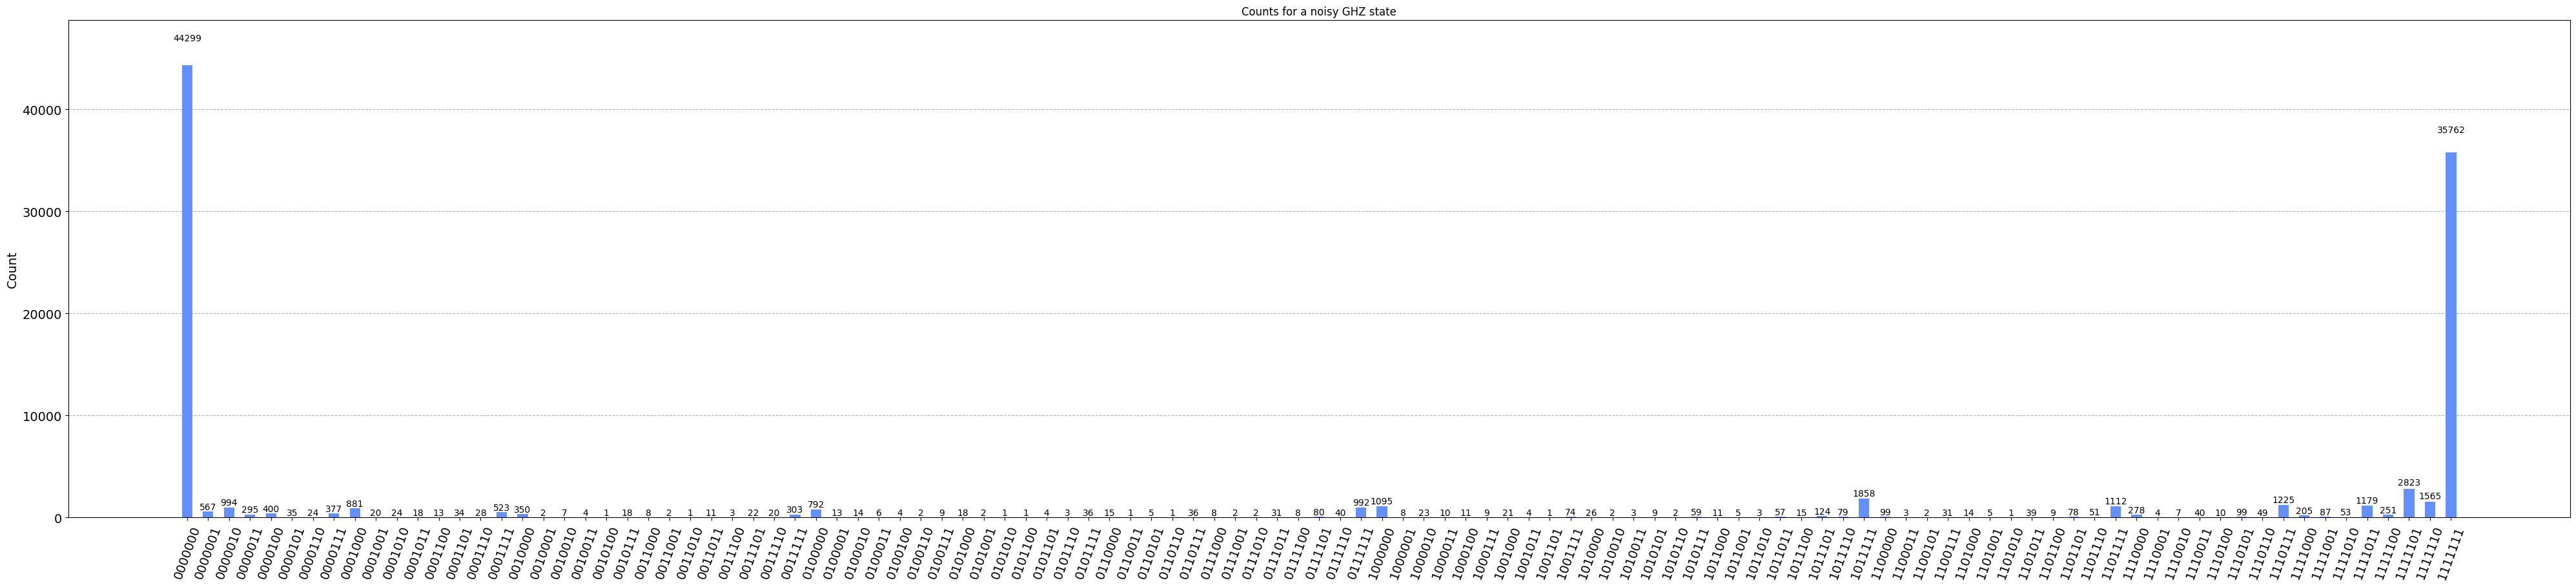

In [14]:
# We now execute the same circuit on a noisy backend (a classical emulator of a real QPU)

noisy_backend = FakeJakarta() # QPU emulator

# Compile the circuit into the native gates of the backend
compiled_circuit = transpile(circuit_to_run, noisy_backend)

# Run the simulation on the noisy backend

noisy_job = execute(compiled_circuit, noisy_backend, shots=shots)
noisy_result = noisy_job.result()
noisy_counts = noisy_result.get_counts()

plot_histogram(noisy_counts, title='Counts for a noisy GHZ state', figsize=(50, 10))

In [15]:
def A_expectation_val(counts):
    probabilities = {outcome: count / shots for outcome, count in counts.items()}
    expectation_val = 0
    for outcome, probability in probabilities.items():
        if outcome == '0'*n_qubits or outcome == '1'*n_qubits:
            expectation_val += probability
    return expectation_val


ideal_expectation_value = A_expectation_val(ideal_counts)
noisy_expectation_value = A_expectation_val(noisy_counts)


print(f"The ideal expectation value is <A> = {ideal_expectation_value}")
print(f"The noisy expectation value is <A> = {noisy_expectation_value}")

The ideal expectation value is <A> = 1.0
The noisy expectation value is <A> = 0.80061


#### Apply zero-noise extrapolation with Mitiq 
Before using Mitiq we need wrap the previous code into a function that takes as input a circuit and returns the noisy expectation value of the observable 
This function will be used by Mitiq as a black box during the error mitigation process.

In [20]:
def execute(compiled_circuit):
    """Executes the input circuits and returns the expectation value of A=|00..0><00..0| + |11..1><11..1|."""
    result = noisy_backend.run(compiled_circuit, shots=shots).result()
    counts = result.get_counts()
    print("Executing a circuit of depth:", compiled_circuit.depth())
    noisy_expectation_value = A_expectation_val(counts)

    return noisy_expectation_value

In [19]:
print(f"The noisy expectation value is <A> = {execute(compiled_circuit)}")

Executing a circuit of depth: 16
The noisy expectation value is <A> = 0.7992900000000001
